In [1]:
import sys
import os
PROJ_PATH = os.getcwd()
SRC_PATH = os.path.join(PROJ_PATH, 'src')
sys.path.append(PROJ_PATH)
sys.path.append(SRC_PATH)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from src.model import FacialGNN, FacialTemporalTransformer, MicroExpressionModel
from src.training import prepare_microexpression_datasets, MicroExpressionDataset, me_collate_fn

train_list, val_list, label_map = prepare_microexpression_datasets(seed=1, subject_independent=False, include_augmented=False)
len(train_list), len(val_list), label_map

In [ ]:
train_dataset = MicroExpressionDataset(train_list, label_map)
val_dataset = MicroExpressionDataset(val_list, label_map)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=me_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=me_collate_fn)

fusion_dim = 256
embed_dim = 256
model = MicroExpressionModel(
    gnn=FacialGNN(fusion_dim=fusion_dim),
    transformer=FacialTemporalTransformer(embed_dim=embed_dim),
    num_classes=len(label_map),
    embed_dim=embed_dim
)

for lm_list, labels, num_frames in train_loader:
    res = model(lm_list, num_frames)
    display(res.shape)
    break

tensor([[ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21,
         22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
         43, 44, 45, 46, 47, 48, 49, 19, 25, 31, 43,  4,  5, 13,  0,  4,  5,  9,
         21, 22, 23, 25, 26, 30, 19, 22, 23, 24, 25, 28, 29, 30, 31, 32, 36, 37,
         31, 37,  1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 20,
         21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40,
         41, 42, 44, 45, 46, 47, 48, 49, 50, 24, 30, 42, 50, 10, 10, 16, 19, 22,
         25, 28, 10, 10, 10, 10, 10, 10, 14, 14, 14, 14, 18, 18, 18, 18, 14, 14,
         18, 18, 43, 47],
        [ 1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
         23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
         44, 45, 46, 47, 48, 49, 50, 24, 30, 42, 50, 10, 10, 16, 19, 22, 25, 28,
         10, 10, 10, 10, 10, 10, 14, 14, 14, 14, 18, 18, 18, 18, 14, 14, 18, 18,
  

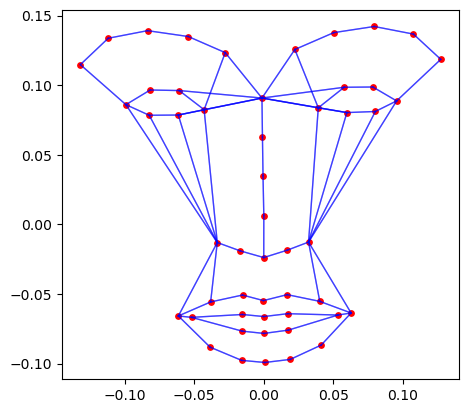

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.procrustes import load_meanface

meanface = load_meanface()

x, edge_index = MicroExpressionModel.build_graph(torch.tensor(meanface))
display(edge_index)

for i in range(edge_index.shape[1]):
    src = edge_index[0, i].item()
    tgt = edge_index[1, i].item()
    plt.plot(
        [x[src, 0], x[tgt, 0]],
        [-x[src, 1], -x[tgt, 1]],
        c='blue', alpha=0.5, linewidth=1
    )

plt.scatter(x[:,0], -x[:, 1], c='red', s=15)
plt.gca().set_aspect('equal')

In [50]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from math import ceil

def process_folder(folder_path, output_base_path, raw_lm_path = None, images_base_path = None, interval = 200):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for csv in csv_files:
        df = pd.read_csv(os.path.join(folder_path, csv), delimiter=';')
        dfs.append(df)
    
    n = len(dfs)
    rows = 2
    cols = ceil(n / rows)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()
    
    for j in range(n, len(axs)):
        axs[j].axis('off')

    raw_lm_df = None
    if raw_lm_path is not None:
        raw_lm_df = pd.read_csv(raw_lm_path, delimiter=';')
    
    def update(frame):
        for j in range(n):
            ax = axs[j]
            ax.clear()
            xs = dfs[j].iloc[frame, 2::2].values
            ys = dfs[j].iloc[frame, 3::2].values
            ax.scatter(xs, -ys, s=5, color='red' if csv_files[j].split('.')[0].endswith('original') else 'blue')
            ax.set_title(csv_files[j], fontsize=8)
            ax.set_xlim(-0.23, 0.23)
            ax.set_ylim(-0.23, 0.23)
        if raw_lm_df is not None:
            ax = axs[n]
            ax.clear()
            xs = raw_lm_df.iloc[frame, 2::2].values
            ys = raw_lm_df.iloc[frame, 3::2].values
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            if images_base_path is not None:
                image_name = raw_lm_df.loc[frame, 'filename']
                image_path = os.path.join(images_base_path, image_name)
                image = cv2.imread(image_path)
                h, w, _ = image.shape
                ax.set_xlim(0, w)
                ax.set_ylim(0, h)
                ax.imshow(image)
                xs = ((xs + 1) / 2) * w
                ys = ((ys + 1) / 2) * h
            ax.scatter(xs, ys, s=5, color='red')
            ax.set_title('raw landmarks', fontsize=8)
            ax.invert_yaxis()
    
    ani = FuncAnimation(fig, update, frames=len(dfs[0]), interval=interval)
    
    output_path = os.path.join(output_base_path, f'{os.path.basename(folder_path)}.gif')
    ani.save(output_path, writer='pillow')
    plt.close(fig)

In [ ]:
base_path = r'data\augmented\casmeii'
raw_lm_base_path = r'data\me_landmarks\casmeii'
images_base_path = r'data\raw\casmeii'
output_base_path = r'data\me_lm_gifs\casmeii'
os.makedirs(output_base_path, exist_ok=True)
output_files = {os.path.basename(f)[:-4] for f in os.listdir(output_base_path)}
for subdir in tqdm(os.listdir(base_path)):
    # if subdir in output_files:
    #     continue
    full_path = os.path.join(base_path, subdir)
    raw_lm_path = os.path.join(raw_lm_base_path, subdir, 'raw_landmarks.csv')
    images_path = os.path.join(images_base_path, f'{subdir}_aligned')
    if os.path.isdir(full_path):
        process_folder(full_path, output_base_path, raw_lm_path, images_path, interval=200)

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def load_epoch(base_path:Path, epoch: int):
    prefix = f"epoch_{epoch}"
    scores = np.load(base_path / f"{prefix}_val_scores.npy")
    attn   = np.load(base_path / f"{prefix}_val_attn_weights.npy")
    lengths = np.load(base_path / f"{prefix}_val_lengths.npy")
    labels = np.load(base_path / f"{prefix}_val_labels.npy")
    preds  = np.load(base_path / f"{prefix}_val_preds.npy")
    return scores, attn, lengths, labels, preds

def plot_attention(
    base_path: Path,
    class_names: list[str],
    epoch: int,
    sample_indices=None,
    labels_path = r'data\augmented\casme3\labels.xlsx',
    num_samples: int = 10,
    mode: str = 'heatmap',
    figsize=None
):
    scores, attn, lengths, labels, preds = load_epoch(base_path, epoch)

    fragments = [Path(path).parts[-2] for path in np.load(base_path / f"val_csv_paths.npy")]
    fragments = [f.split('_') for f in fragments]
    df = pd.read_excel(labels_path, dtype=object)
    
    if sample_indices is None:
        sample_indices = range(num_samples)
    sample_indices = list(sample_indices)
    n_samples = len(sample_indices)
    
    sample_labels = []
    sample_fragments = []
    for idx in sample_indices:
        sample_fragments.append(fragments[idx])
        true = class_names[labels[idx]]
        pred = class_names[preds[idx]]
        mark = "✓" if labels[idx] == preds[idx] else "✗"
        sample_labels.append(f"{idx:3d} | {true} → {pred} {mark}")
    
    apex_indicies = []
    for subject, filename, onset in sample_fragments:
        row = df[(df['Subject'] == subject) & (df['Filename'] == filename) & (df['Onset'] == onset)].iloc[0]
        apex_indicies.append(int(row['Apex']) - int(row['Onset']))

    if mode == 'heatmap':
        global_max_len = lengths.max()
        scores_padded = np.full((n_samples, global_max_len), np.nan)
        attn_padded   = np.full((n_samples, global_max_len), np.nan)
        
        for i, idx in enumerate(sample_indices):
            l = lengths[idx]
            scores_padded[i, :l] = scores[idx, :l]
            attn_padded[i, :l] = attn[idx, :l]
        
        s_min, s_max = np.nanmin(scores_padded), np.nanmax(scores_padded)
        a_min, a_max = np.nanmin(attn_padded), np.nanmax(attn_padded)
        
        fig_height = max(3, 0.45 * n_samples)
        fig, axs = plt.subplots(n_samples, 2, figsize=figsize or (16, fig_height),gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1, 'hspace': 0.05})
        
        if n_samples == 1:
            axs = axs.reshape(1, -1)
        
        for i in range(n_samples):
            im1 = axs[i, 0].imshow(scores_padded[i:i+1], aspect='auto', cmap='Blues', vmin=s_min, vmax=s_max)
            axs[i, 0].set_yticks([]); axs[i, 0].set_xticks([])
            axs[i, 0].set_ylabel(sample_labels[i], rotation=0, ha='right', va='center', fontsize=11)

            im2 = axs[i, 1].imshow(attn_padded[i:i+1], aspect='auto', cmap='Reds', vmin=a_min, vmax=a_max)
            axs[i, 1].set_yticks([]); axs[i, 1].set_xticks([])

            apex = apex_indicies[i]
            if not np.isnan(apex) and apex < lengths[sample_indices[i]]:
                apex = int(apex)
                axs[i, 0].axvline(apex, color='black', linewidth=1, linestyle='--')
                axs[i, 1].axvline(apex, color='black', linewidth=1, linestyle='--')
        
        fig.colorbar(im1, ax=axs[:, 0], fraction=0.046, pad=0.04, label='Raw Scores')
        fig.colorbar(im2, ax=axs[:, 1], fraction=0.046, pad=0.04, label='Attention Weights')
        
        fig.suptitle(f"Epoch {epoch} — Heatmap ({n_samples} samples)", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    
    elif mode == 'line':
        fig_height = max(3, 2.0 * n_samples)
        fig, axs = plt.subplots(n_samples, 2, figsize=figsize or (16, fig_height), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.25, 'hspace': 0.2})
        
        if n_samples == 1:
            axs = axs.reshape(1, -1)
        
        for i in range(n_samples):
            idx = sample_indices[i]
            l = lengths[idx]
            frames = np.arange(l)
            
            axs[i, 0].plot(frames, scores[idx, :l], color='tab:blue', linewidth=2)
            axs[i, 0].grid(alpha=0.3)
            axs[i, 0].set_ylabel(sample_labels[i], rotation=0, ha='right', va='center', fontsize=11)
            
            axs[i, 1].plot(frames, attn[idx, :l], color='tab:red', linewidth=2.5)
            axs[i, 1].grid(alpha=0.3)

            apex = apex_indicies[i]
            if not np.isnan(apex) and apex < l:
                apex = int(apex)
                axs[i, 0].axvline(apex, color='black', linewidth=2, linestyle='-')
                axs[i, 1].axvline(apex, color='black', linewidth=2, linestyle='-')
        
        fig.text(0.5, 0.98, f"Epoch {epoch} — Line plots ({n_samples} samples)", fontsize=16, ha='center', va='top')        
        plt.subplots_adjust(top=0.96, bottom=0.06, left=0.12, right=0.95)
        plt.show()

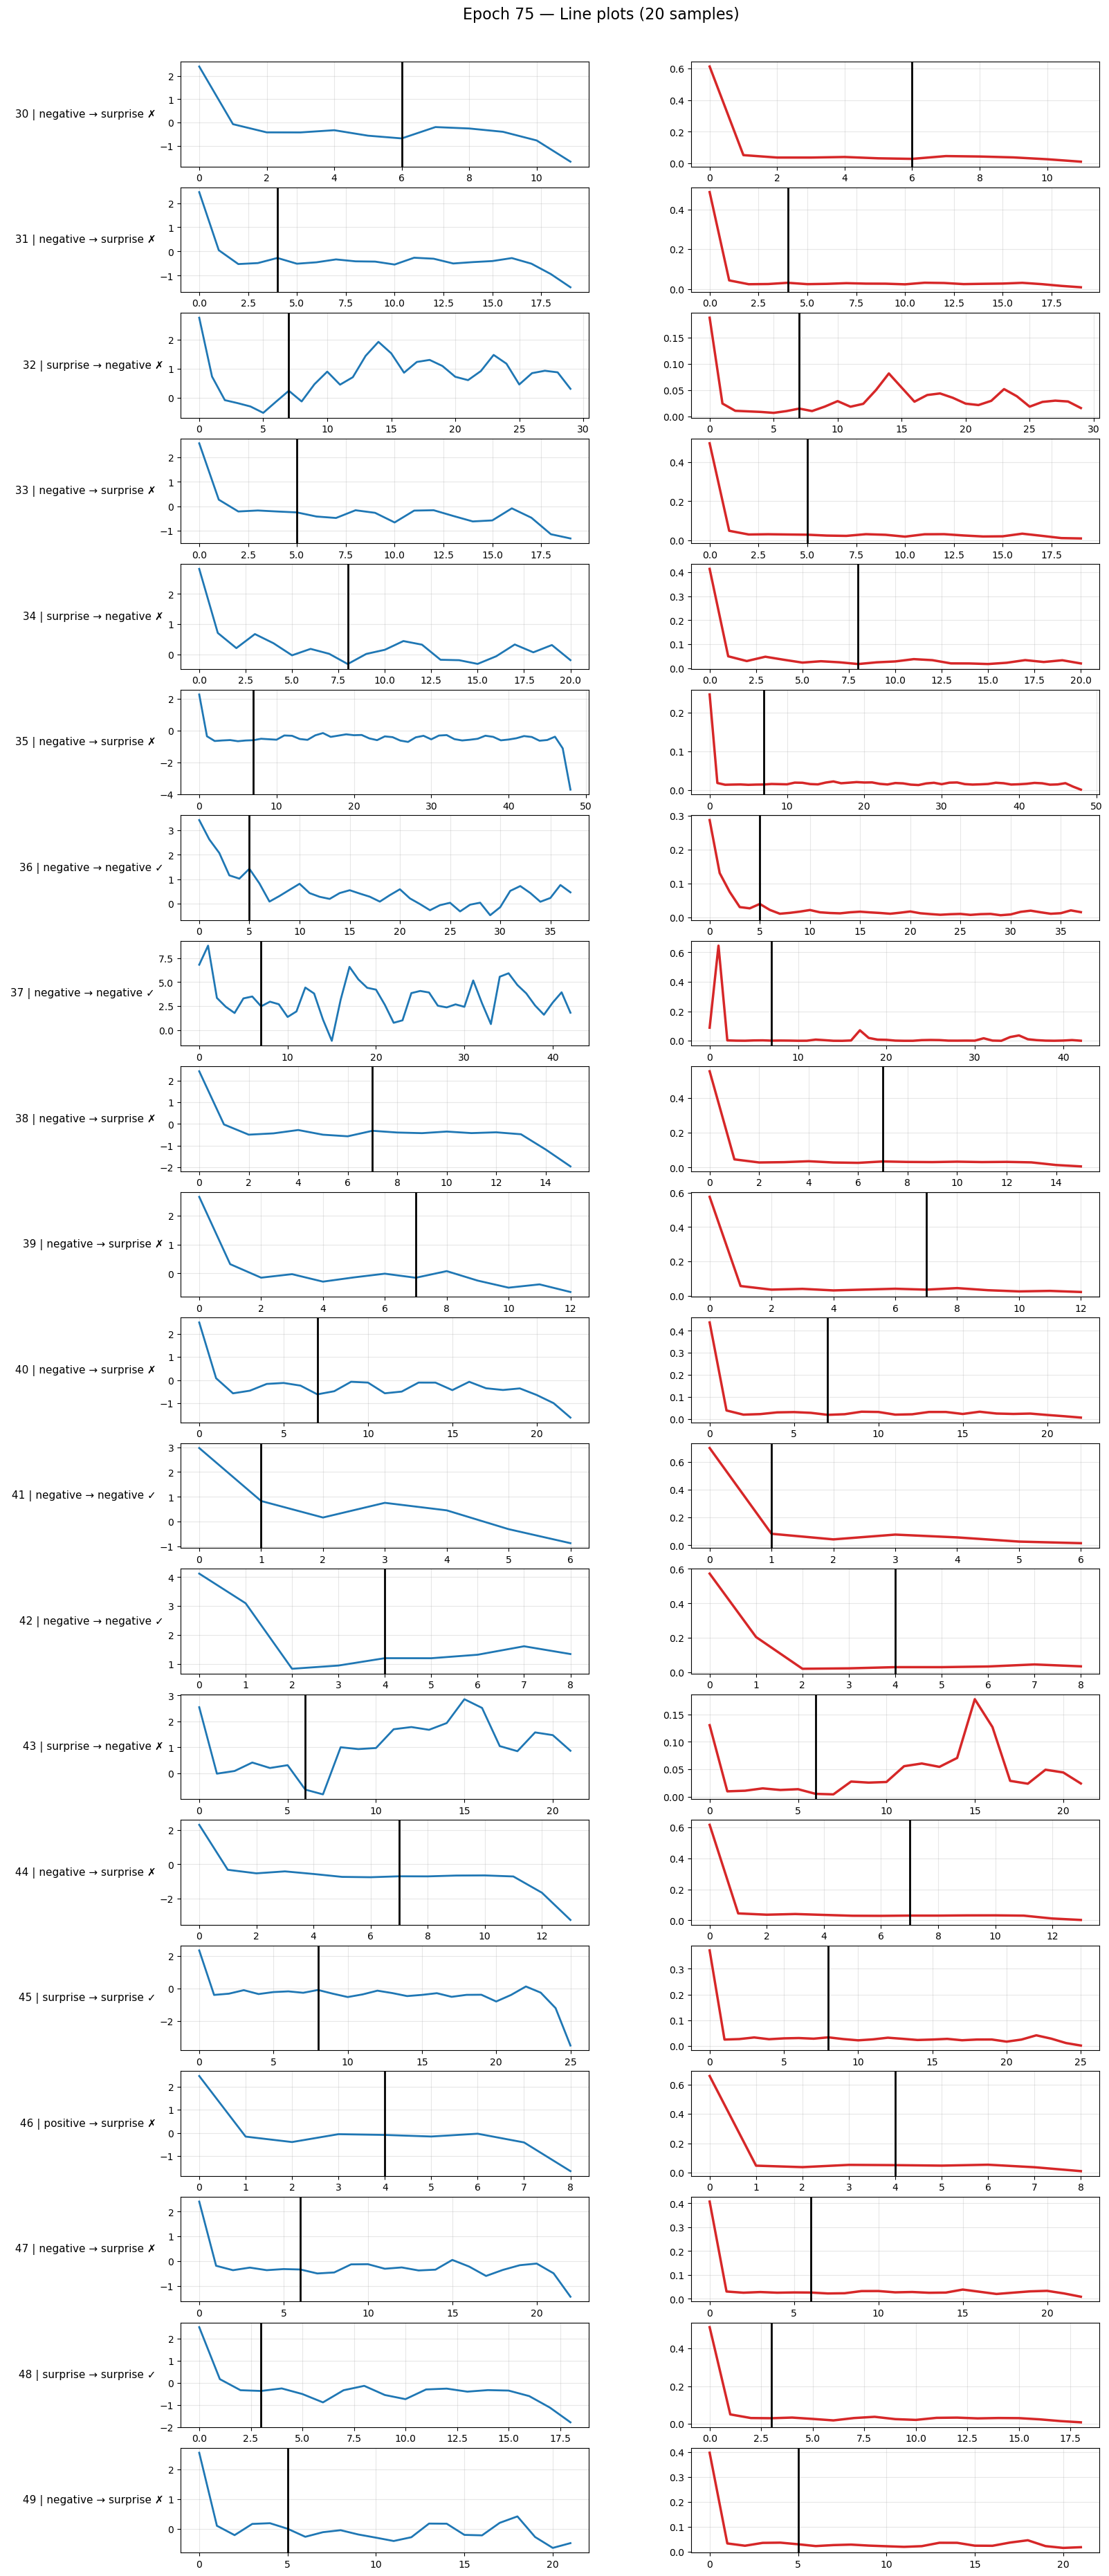

In [150]:
base_path = Path(r"mlruns\746171381191466352\7078ad43d372480cb36b7b3b8cd8ff62\artifacts")
class_names = ['negative', 'positive', 'surprise']
plot_attention(base_path, class_names, 75, range(30, 50), mode='line')